In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import keras 
from keras.models import Sequential
from keras.layers import Dense
import warnings

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281,1,1824,1824.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202,1,1826,1824.0,1,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272,1,1828,1824.0,2,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868,0,1830,1860.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280,1,1830,1824.0,3,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375


In [3]:
missing_presidents=pd.DataFrame(columns=['year','president_party'])
missing_presidents=missing_presidents.append({'year': 1824, 'president_party': 'R'},\
                          ignore_index=True)
missing_presidents=missing_presidents.append({'year': 1824, 'president_party': 'R'},\
                          ignore_index=True)

In [4]:
#drop observations where president party is not defined
house_df=house_df.drop(house_df.loc[house_df['president_party']=="0"].index)

In [5]:
#plot
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy):
    #plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Scores of all fitted models on training vs validation set', fontsize=24, y=1)
    ax.barh(models_names, scores_train, alpha=0.5, label='train set') 
    ax.barh(models_names, scores_val, alpha=0.5, label='val set')   
    ax.barh(models_names, scores_val_mut_escl, alpha=0.5, label='val set mut. excl.')  
    max_scores=np.maximum(np.maximum(np.array(scores_train),np.array(scores_val)),np.array(scores_val_mut_escl))
    for i, v in enumerate(max_scores):
        ax.text(v+0.005, i, '{:<.2%}'.format(v), color='black', fontsize=12)
    min_scores=np.minimum(np.minimum(np.array(scores_train),np.array(scores_val)),np.array(scores_val_mut_escl))
    for i, v in enumerate(min_scores):
        ax.text(v-0.03, i, '{:>.2%}'.format(v), color='white', fontsize=12)    
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    #ax.text(baseline_accuracy, 0, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.25, 0.88));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy)

In [6]:
#plt.hist(house_df[house_df['first_time_elected']>0]['first_time_elected'])

In [7]:
#Actual seats repartition in the House of Representatives
display(house_df.loc[(house_df['year']==2018)][['last_D_house_seats', 'last_R_house_seats']].iloc[0])

last_D_house_seats    194.0
last_R_house_seats    241.0
Name: 9130, dtype: float64

In [8]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [9]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    house_df_all_districts['partisanship']=house_df_all_districts['partisanship'].astype(int)
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1).fillna(0)
    out_df['partisanship']=out_df['partisanship'].astype(int)
    return out_df

In [10]:
def preprocess(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    #df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    #df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    df_out.drop('first_time_elected', axis=1)
               
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #drop year
    #df_out=df_out.drop('year', axis=1)
    
    return df_out

In [11]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts):
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_train)[:,1]
    y_pred_test=model.predict_proba(x_test)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_train.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_test.index, columns=['abs_won_proba'])

    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_train[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_test[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    #display(out_df[(out_df['state']=='Louisiana')&(out_df['district']=='District 3')]) #&(out_df['year']==2018)])
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        #display warning
        warnings.warn("{} districts have no winner or more than one winner".format(len(NotJustOneWinner), DeprecationWarning))
        print('List of affected districts:')
        display(districtWinners[districtWinners['won_pred']!=1])
        print('First occurrence from list:')
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_test).join(y_pred_test_df).dropna()
        print('Data of the occurrence from list:')
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #manage conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state']:
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district']:
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict in {}, {} is between candidates from the same party, so we predict as winner in the district the first candidate of this party'.format(state, district))
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    #Accu_val_2=sum(out_df['won_pred']==y_test)/len(out_df)
    
    #display(out_df.head())
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [12]:
#plot
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'Full training set')
    ax.plot(years, scores_train_CV, label = 'CV mean score')
    ax.plot(years, scores_CV_mutExcl, label = 'CV mean mutually exclusive score')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
    
def modelListTrain(modelList, train_df, years):
    train_data=train_df.copy()
    for i in range(len(modelList)):
        model=modelList[i]
        #list with training accuracy
        train_acc=[]
        #list with validation accuracy
        val_acc=[]
        #list with mutually exclusive validation accuracy
        val_acc_2=[]
        #list with uncertainties
        n_uncertain=[]
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))

            #split dataset
            x_train, y_train, x_test, y_test, house_df_districts = splitDf(train_data, year)

            #preprocess
            x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
            x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

            #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
            x_train_preprocess=x_train_preprocess[list(x_test_preprocess)]
            
            #fit model
            fitted_model=model['model'].fit(x_train_preprocess, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)
            
            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

            #print how many republican, how many democrat districts
            DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
            REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
            print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))
            
            #print uncertainties
            uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
            n_uncertainties=len(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])
            n_uncertain.append(n_uncertainties)
            print('Uncertainties: {}\n'.format(n_uncertainties))
        title='Scores or model {} cross-validated through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, title, xlabel='Year')
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['N. uncertainties']=np.mean(n_uncertain)
    display(modelList)

In [13]:
#test set on 2018 data, train set on previous data
yearStart=1868
train_data, test_data = house_df[(house_df['year']>=yearStart)&(house_df['year']!=2018)], house_df[house_df['year']==2018]

In [15]:
#Years lists
Midterm_recent_years=2014-4*np.arange(10)
All_recent_years=2016-2*np.arange(20)
display(Midterm_recent_years)
display(All_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

array([2016, 2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000, 1998, 1996,
       1994, 1992, 1990, 1988, 1986, 1984, 1982, 1980, 1978])

In [16]:
modelList=[]
#Logistic regression
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#k-NN
model=dict()
n_neighbors=4
model['name']='k-NN, k={}'.format(n_neighbors)
model['model']=KNeighborsClassifier(n_neighbors=n_neighbors)
modelList.append(model)
model=dict()
#LDA
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
model=dict()
#QDA
model['name']='QDA'
model['model']=QuadraticDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
#Simple decision tree 
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Simple decision tree 
max_depth=11
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Random forest
max_depth=11
n_trees=50
model=dict()
model['name']='Random Forest of {} depth-{} trees'.format(n_trees, max_depth)
model['model']=RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth )
modelList.append(model)
#Boosting 
max_depth=1
n_trees=800
lrate=0.05
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_trees, learning_rate=lrate)
model=dict()
model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, max_depth)
model['model']=abc
modelList.append(model)  

years=Midterm_recent_years

model: Logistic Regression CV=5
year: 2014
Training accuracy: 97.28%
Validation accuracy: 98.25%
Mutually exclusive validation accuracy: 99.75%

N. Democrat districts: 187
N. Republican districts: 243
Uncertainties: 28

model: Logistic Regression CV=5
year: 2010
Training accuracy: 97.54%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 98.48%

N. Democrat districts: 127
N. Republican districts: 148
Uncertainties: 56

model: Logistic Regression CV=5
year: 2006
Training accuracy: 97.39%
Validation accuracy: 97.09%
Mutually exclusive validation accuracy: 99.22%

N. Democrat districts: 150
N. Republican districts: 122
Uncertainties: 30

model: Logistic Regression CV=5
year: 2002
Training accuracy: 97.30%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 98.61%

N. Democrat districts: 113
N. Republican districts: 120
Uncertainties: 10

model: Logistic Regression CV=5
year: 1998
Training accuracy: 97.31%
Validation accuracy: 99.57%
Mutually exclusive vali

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
28,California,District 17,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8113,California,District 17,0.0,1.0,1.0,2.0,0.5
8119,California,District 17,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
8113,California,District 17,1.0,0.0,2014.0,2012.0,1.0,5.5,0.0,0.0,0.0,0.48,1.0,0.0,1.0,0.0,6.127138,0.537931,0.462069,1.0
8119,California,District 17,0.0,0.0,2014.0,2016.0,0.0,5.5,0.0,0.0,0.0,0.48,1.0,0.0,1.0,0.0,6.146467,0.537931,0.462069,1.0


The conflict in California, District 17 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.94%
Validation accuracy: 95.25%
Mutually exclusive validation accuracy: 97.00%

N. Democrat districts: 195
N. Republican districts: 235
Uncertainties: 24

model: k-NN, k=4
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 25 districts have no winner or more than one winner


,state,district,won_pred
1,Alabama,District 2,2.0
8,Arizona,District 1,2.0
12,Arizona,District 5,2.0
74,Colorado,District 3,2.0
95,Florida,District 2,2.0
98,Florida,District 22,2.0
100,Florida,District 24,2.0
119,Georgia,District 8,2.0
123,Idaho,District 1,2.0
128,Indiana,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6490,Alabama,District 2,1.0,1.0,1.0,2.0,0.5
6491,Alabama,District 2,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
6490,Alabama,District 2,0.0,1.0,2010.0,2010.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,6.095839,0.409195,0.409195,1.0
6491,Alabama,District 2,1.0,0.0,2010.0,2008.0,1.0,9.4,0.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.409195,0.590805,1.0


Training accuracy: 98.03%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 94.51%

N. Democrat districts: 126
N. Republican districts: 124
Uncertainties: 56

model: k-NN, k=4
year: 2006
Training accuracy: 98.01%
Validation accuracy: 86.21%
Mutually exclusive validation accuracy: 95.34%

N. Democrat districts: 138
N. Republican districts: 134
Uncertainties: 5

model: k-NN, k=4
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
157,Maryland,District 8,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4439,Maryland,District 8,1.0,1.0,1.0,2.0,0.5
4445,Maryland,District 8,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
4439,Maryland,District 8,1.0,1.0,2002.0,1988.0,7.0,5.7,0.0,1.0,1.0,0.494,1.0,1.0,0.0,0.0,5.184882,0.510393,0.510393,1.0
4445,Maryland,District 8,0.0,0.0,2002.0,2002.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,1.0,0.0,0.0,5.184882,0.510393,0.489607,1.0


Training accuracy: 97.84%
Validation accuracy: 99.07%
Mutually exclusive validation accuracy: 98.38%

N. Democrat districts: 112
N. Republican districts: 120
Uncertainties: 9

model: k-NN, k=4
year: 1998
Training accuracy: 97.96%
Validation accuracy: 99.13%
Mutually exclusive validation accuracy: 100.00%

N. Democrat districts: 65
N. Republican districts: 57
Uncertainties: 0

model: k-NN, k=4
year: 1994
Training accuracy: 98.01%
Validation accuracy: 91.02%
Mutually exclusive validation accuracy: 97.60%

N. Democrat districts: 43
N. Republican districts: 43
Uncertainties: 1

model: k-NN, k=4
year: 1990
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 4 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
8,California,District 17,2.0
37,California,District 44,2.0
73,Virginia,District 8,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3040,California,District 1,1.0,1.0,1.0,2.0,0.5
3050,California,District 1,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
3040,California,District 1,0.0,1.0,1990.0,1990.0,0.0,5.9,0.0,1.0,1.0,0.609,0.0,0.0,0.0,5.779518,0.402299,0.402299,1.0
3050,California,District 1,1.0,0.0,1990.0,1984.0,3.0,5.9,0.0,1.0,1.0,0.609,0.0,0.0,0.0,5.779518,0.402299,0.597701,1.0


Training accuracy: 98.04%
Validation accuracy: 97.16%
Mutually exclusive validation accuracy: 97.16%

N. Democrat districts: 41
N. Republican districts: 29
Uncertainties: 8

model: k-NN, k=4
year: 1986
Training accuracy: 97.98%
Validation accuracy: 99.24%
Mutually exclusive validation accuracy: 100.00%

N. Democrat districts: 36
N. Republican districts: 31
Uncertainties: 2

model: k-NN, k=4
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
48,Delaware,At-Large,2.0
66,Virginia,District 8,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2515,California,District 1,0.0,1.0,1.0,2.0,0.5
2516,California,District 1,1.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
2515,California,District 1,0.0,0.0,1982.0,1982.0,0.0,10.4,0.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.441379,0.558621,1.0
2516,California,District 1,1.0,1.0,1982.0,1964.0,5.0,10.4,0.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.441379,0.441379,1.0


Training accuracy: 98.02%
Validation accuracy: 97.66%
Mutually exclusive validation accuracy: 97.66%

N. Democrat districts: 33
N. Republican districts: 31
Uncertainties: 6

model: k-NN, k=4
year: 1978
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
27,California,District 35,2.0
42,Colorado,District 3,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2307,California,District 35,1.0,1.0,1.0,2.0,0.5
2308,California,District 35,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
2307,California,District 35,0.0,1.0,1978.0,1980.0,0.0,5.8,0.0,1.0,0.0,0.455,0.0,0.0,0.0,5.525916,0.328736,0.328736,1.0
2308,California,District 35,1.0,0.0,1978.0,1976.0,1.0,5.8,0.0,1.0,0.0,0.455,0.0,0.0,0.0,5.525916,0.328736,0.671264,1.0


Training accuracy: 98.02%
Validation accuracy: 81.58%
Mutually exclusive validation accuracy: 91.23%

N. Democrat districts: 35
N. Republican districts: 22
Uncertainties: 8

model: LDA
year: 2014
Training accuracy: 97.28%
Validation accuracy: 98.25%
Mutually exclusive validation accuracy: 97.00%

N. Democrat districts: 195
N. Republican districts: 235
Uncertainties: 28

model: LDA
year: 2010
Training accuracy: 97.54%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 90.91%

N. Democrat districts: 151
N. Republican districts: 124
Uncertainties: 56

model: LDA
year: 2006
Training accuracy: 97.39%
Validation accuracy: 97.09%
Mutually exclusive validation accuracy: 95.73%

N. Democrat districts: 139
N. Republican districts: 133
Uncertainties: 30

model: LDA
year: 2002
Training accuracy: 97.30%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 99.07%

N. Democrat districts: 114
N. Republican districts: 119
Uncertainties: 10

model: LDA
year: 1998
Training

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
127,Hawaii,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8138,Hawaii,District 1,0.0,0.949535,1.0,1.89907,0.5
8145,Hawaii,District 1,1.0,0.949535,1.0,1.89907,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
8138,Hawaii,District 1,0.0,0.0,2014.0,2014.0,0.0,4.5,0.0,0.0,0.0,0.48,1.0,0.0,1.0,0.0,6.258947,0.537931,0.462069,0.949535
8145,Hawaii,District 1,0.0,1.0,2014.0,2010.0,0.0,4.5,0.0,0.0,0.0,0.48,1.0,0.0,1.0,0.0,6.024095,0.537931,0.537931,0.949535


Training accuracy: 97.30%
Validation accuracy: 98.25%
Mutually exclusive validation accuracy: 96.88%

N. Democrat districts: 194
N. Republican districts: 235
Uncertainties: 28

model: Decision Tree, depth=4
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 5 districts have no winner or more than one winner


,state,district,won_pred
176,Mississippi,District 4,2.0
198,New York,District 20,2.0
202,New York,District 24,2.0
246,Texas,District 23,2.0
250,Texas,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6485,Mississippi,District 4,1.0,0.938383,1.0,1.876765,0.5
6486,Mississippi,District 4,0.0,0.938383,1.0,1.876765,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
6485,Mississippi,District 4,0.0,1.0,2010.0,2010.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,5.264160,0.409195,0.409195,0.938383
6486,Mississippi,District 4,0.0,0.0,2010.0,2002.0,3.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,5.917407,0.409195,0.590805,0.938383


Training accuracy: 97.56%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 91.48%

N. Democrat districts: 147
N. Republican districts: 123
Uncertainties: 56

model: Decision Tree, depth=4
year: 2006
Training accuracy: 97.40%
Validation accuracy: 97.09%
Mutually exclusive validation accuracy: 95.73%

N. Democrat districts: 139
N. Republican districts: 133
Uncertainties: 30

model: Decision Tree, depth=4
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
77,Colorado,District 7,2.0
141,Kentucky,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4367,Colorado,District 7,1.0,0.94835,1.0,1.8967,0.5
4368,Colorado,District 7,0.0,0.94835,1.0,1.8967,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
4367,Colorado,District 7,0.0,1.0,2002.0,2002.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,0.510393,0.94835
4368,Colorado,District 7,0.0,0.0,2002.0,2002.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,0.489607,0.94835


Training accuracy: 97.31%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 99.07%

N. Democrat districts: 112
N. Republican districts: 119
Uncertainties: 10

model: Decision Tree, depth=4
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
28,California,District 36,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3894,California,District 36,1.0,0.96776,1.0,1.935521,0.5
3895,California,District 36,0.0,0.96776,1.0,1.935521,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
3894,California,District 36,0.0,1.0,1998.0,1998.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,0.525346,0.96776
3895,California,District 36,0.0,0.0,1998.0,2011.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,0.474654,0.96776


Training accuracy: 97.34%
Validation accuracy: 99.57%
Mutually exclusive validation accuracy: 99.57%

N. Democrat districts: 65
N. Republican districts: 56
Uncertainties: 2

model: Decision Tree, depth=4
year: 1994
Training accuracy: 97.37%
Validation accuracy: 98.20%
Mutually exclusive validation accuracy: 97.60%

N. Democrat districts: 43
N. Republican districts: 43
Uncertainties: 6

model: Decision Tree, depth=4
year: 1990
Training accuracy: 97.38%
Validation accuracy: 97.16%
Mutually exclusive validation accuracy: 97.16%

N. Democrat districts: 41
N. Republican districts: 33
Uncertainties: 8

model: Decision Tree, depth=4
year: 1986
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
61,Utah,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2738,Utah,District 1,0.0,0.968258,1.0,1.936517,0.5
2739,Utah,District 1,1.0,0.968258,1.0,1.936517,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
2738,Utah,District 1,0.0,0.0,1986.0,1970.0,1.0,7.0,0.0,0.0,1.0,0.528,0.0,0.0,0.0,5.400373,0.418391,0.581609,0.968258
2739,Utah,District 1,1.0,1.0,1986.0,1982.0,2.0,7.0,0.0,0.0,1.0,0.528,0.0,0.0,0.0,5.400373,0.418391,0.418391,0.968258


Training accuracy: 97.36%
Validation accuracy: 99.24%
Mutually exclusive validation accuracy: 99.24%

N. Democrat districts: 36
N. Republican districts: 30
Uncertainties: 2

model: Decision Tree, depth=4
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
48,Delaware,At-Large,2.0
66,Virginia,District 8,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2515,California,District 1,0.0,0.968803,1.0,1.937605,0.5
2516,California,District 1,1.0,0.968803,1.0,1.937605,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
2515,California,District 1,0.0,0.0,1982.0,1982.0,0.0,10.4,0.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.441379,0.558621,0.968803
2516,California,District 1,1.0,1.0,1982.0,1964.0,5.0,10.4,0.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.441379,0.441379,0.968803


Training accuracy: 97.39%
Validation accuracy: 97.66%
Mutually exclusive validation accuracy: 97.66%

N. Democrat districts: 33
N. Republican districts: 31
Uncertainties: 6

model: Decision Tree, depth=4
year: 1978
Training accuracy: 97.43%
Validation accuracy: 94.74%
Mutually exclusive validation accuracy: 94.74%

N. Democrat districts: 32
N. Republican districts: 27
Uncertainties: 12

model: Decision Tree, depth=11
year: 2014
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 9 districts have no winner or more than one winner


,state,district,won_pred
11,Arizona,District 4,2.0
88,Florida,District 11,2.0
94,Florida,District 17,2.0
96,Florida,District 19,2.0
106,Florida,District 3,2.0
132,Illinois,District 10,2.0
237,Nevada,District 4,2.0
239,New Hampshire,District 2,2.0
257,New York,District 11,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
7991,Arizona,District 4,0.0,0.0,1.0,0.0,NaN
8001,Arizona,District 4,1.0,0.0,1.0,0.0,NaN


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
7991,Arizona,District 4,0.0,0.0,2014.0,0.0,0.0,9.4,0.0,0.0,0.0,0.48,1.0,0.0,1.0,0.0,4.657672,0.537931,0.462069,0.0
8001,Arizona,District 4,1.0,1.0,2014.0,2012.0,1.0,9.4,0.0,0.0,0.0,0.48,1.0,0.0,1.0,0.0,5.358852,0.537931,0.537931,0.0


Training accuracy: 98.72%
Validation accuracy: 97.38%
Mutually exclusive validation accuracy: 96.38%

N. Democrat districts: 192
N. Republican districts: 229
Uncertainties: 28

model: Decision Tree, depth=11
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 27 districts have no winner or more than one winner


,state,district,won_pred
6,Alabama,District 7,2.0
10,Arizona,District 3,2.0
61,California,District 48,2.0
66,California,District 52,2.0
75,Colorado,District 4,2.0
77,Colorado,District 6,2.0
88,Florida,District 13,2.0
90,Florida,District 15,2.0
101,Florida,District 25,2.0
123,Idaho,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6147,Alabama,District 7,0.0,0.0,1.0,0.0,NaN
6176,Alabama,District 7,1.0,0.0,1.0,0.0,NaN


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
6147,Alabama,District 7,0.0,0.0,2010.0,2010.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,0.0,1.0,0.0,6.236375,0.409195,0.590805,0.0
6176,Alabama,District 7,0.0,1.0,2010.0,0.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,0.0,1.0,0.0,4.454850,0.409195,0.409195,0.0


Training accuracy: 98.63%
Validation accuracy: 88.26%
Mutually exclusive validation accuracy: 89.20%

N. Democrat districts: 136
N. Republican districts: 112
Uncertainties: 33

model: Decision Tree, depth=11
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
74,Colorado,District 3,2.0
148,Kentucky,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5143,Colorado,District 3,1.0,1.0,1.0,2.0,0.5
5144,Colorado,District 3,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
5143,Colorado,District 3,0.0,1.0,2006.0,2010.0,0.0,4.4,0.0,0.0,1.0,0.494,1.0,1.0,0.0,0.0,6.141265,0.534562,0.534562,1.0
5144,Colorado,District 3,1.0,0.0,2006.0,2006.0,0.0,4.4,0.0,0.0,1.0,0.494,1.0,1.0,0.0,0.0,6.141265,0.534562,0.465438,1.0


Training accuracy: 98.62%
Validation accuracy: 97.09%
Mutually exclusive validation accuracy: 94.95%

N. Democrat districts: 137
N. Republican districts: 133
Uncertainties: 30

model: Decision Tree, depth=11
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
77,Colorado,District 7,2.0
79,Connecticut,District 2,2.0
141,Kentucky,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4367,Colorado,District 7,1.0,0.967742,1.0,1.935484,0.5
4368,Colorado,District 7,0.0,0.967742,1.0,1.935484,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
4367,Colorado,District 7,0.0,1.0,2002.0,2002.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,0.510393,0.967742
4368,Colorado,District 7,0.0,0.0,2002.0,2002.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,0.489607,0.967742


Training accuracy: 98.58%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 99.30%

N. Democrat districts: 113
N. Republican districts: 117
Uncertainties: 10

model: Decision Tree, depth=11
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
28,California,District 36,2.0
71,Missouri,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3894,California,District 36,1.0,0.989583,1.0,1.979167,0.5
3895,California,District 36,0.0,0.989583,1.0,1.979167,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
3894,California,District 36,0.0,1.0,1998.0,1998.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,0.525346,0.989583
3895,California,District 36,0.0,0.0,1998.0,2011.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,0.474654,0.989583


Training accuracy: 98.42%
Validation accuracy: 99.13%
Mutually exclusive validation accuracy: 99.13%

N. Democrat districts: 64
N. Republican districts: 56
Uncertainties: 2

model: Decision Tree, depth=11
year: 1994
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3382,California,District 1,1.0,0.0,1.0,0.0,NaN
3383,California,District 1,0.0,0.0,1.0,0.0,NaN


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
3382,California,District 1,0.0,1.0,1994.0,1990.0,1.0,5.8,0.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.40553,0.40553,0.0
3383,California,District 1,1.0,0.0,1994.0,0.0,0.0,5.8,0.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.40553,0.59447,0.0


Training accuracy: 98.50%
Validation accuracy: 97.60%
Mutually exclusive validation accuracy: 98.20%

N. Democrat districts: 42
N. Republican districts: 43
Uncertainties: 6

model: Decision Tree, depth=11
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 3 districts have no winner or more than one winner


List of affected districts:


,state,district,won_pred
0,California,District 1,2.0
8,California,District 17,2.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3040,California,District 1,1.0,1.0,1.0,2.0,0.5
3050,California,District 1,0.0,1.0,1.0,2.0,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
3040,California,District 1,0.0,1.0,1990.0,1990.0,0.0,5.9,0.0,1.0,1.0,0.609,0.0,0.0,0.0,5.779518,0.402299,0.402299,1.0
3050,California,District 1,1.0,0.0,1990.0,1984.0,3.0,5.9,0.0,1.0,1.0,0.609,0.0,0.0,0.0,5.779518,0.402299,0.597701,1.0


Training accuracy: 98.74%
Validation accuracy: 97.16%
Mutually exclusive validation accuracy: 97.87%

N. Democrat districts: 42
N. Republican districts: 29
Uncertainties: 8

model: Decision Tree, depth=11
year: 1986
Training accuracy: 98.39%
Validation accuracy: 99.24%
Mutually exclusive validation accuracy: 98.48%

N. Democrat districts: 37
N. Republican districts: 30
Uncertainties: 2

model: Decision Tree, depth=11
year: 1982
Training accuracy: 98.39%
Validation accuracy: 97.66%
Mutually exclusive validation accuracy: 96.88%

N. Democrat districts: 35
N. Republican districts: 32
Uncertainties: 6

model: Decision Tree, depth=11
year: 1978
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
55,Utah,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2287,Utah,District 1,0.0,0.0,1.0,0.0,NaN
2303,Utah,District 1,1.0,0.0,1.0,0.0,NaN


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,last_own_party_Seats,abs_won_proba
2287,Utah,District 1,1.0,0.0,1978.0,1972.0,3.0,5.8,0.0,1.0,0.0,0.455,0.0,0.0,1.0,5.400373,0.328736,0.671264,0.0
2303,Utah,District 1,0.0,1.0,1978.0,0.0,0.0,5.8,0.0,1.0,0.0,0.455,0.0,0.0,1.0,5.400373,0.328736,0.328736,0.0


Training accuracy: 98.52%
Validation accuracy: 93.86%
Mutually exclusive validation accuracy: 92.11%

N. Democrat districts: 36
N. Republican districts: 22
Uncertainties: 12

model: Random Forest of 50 depth-11 trees
year: 2014
Training accuracy: 98.16%
Validation accuracy: 97.75%
Mutually exclusive validation accuracy: 96.75%

N. Democrat districts: 194
N. Republican districts: 236
Uncertainties: 27

model: Random Forest of 50 depth-11 trees
year: 2010
Training accuracy: 98.31%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 90.91%

N. Democrat districts: 151
N. Republican districts: 124
Uncertainties: 56

model: Random Forest of 50 depth-11 trees
year: 2006
Training accuracy: 98.31%
Validation accuracy: 97.09%
Mutually exclusive validation accuracy: 95.73%

N. Democrat districts: 139
N. Republican districts: 133
Uncertainties: 30

model: Random Forest of 50 depth-11 trees
year: 2002
Training accuracy: 98.16%
Validation accuracy: 98.84%
Mutually exclusive validatio

[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.9736572520010747,
  'score validation': 0.9754435848268559,
  'score val mut exclusive': 0.9892962557103491,
  'N. uncertainties': 16.0},
 {'name': 'k-NN, k=4',
  'model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=4, p=2,
             weights='uniform'),
  'score train': 0.9798641694483543,
  'score validation': 0.9410253930683163,
  'score val mut exclusive': 0.9688754828144001,
  'N. uncertainties': 11.9},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solve

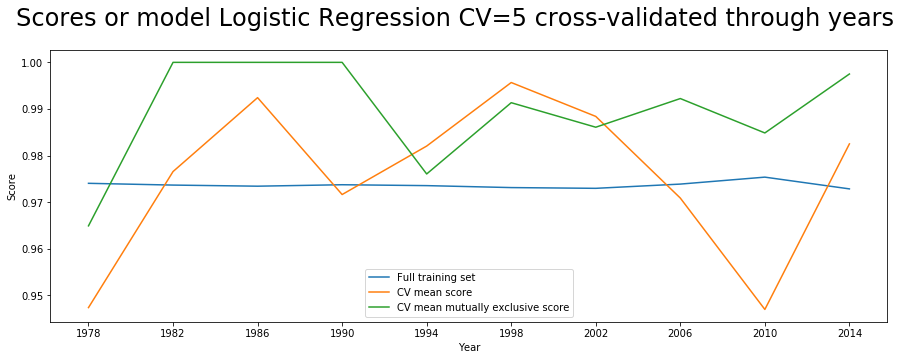

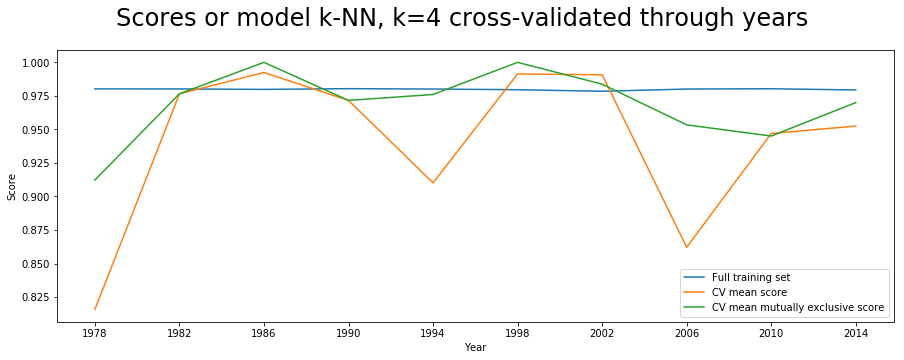

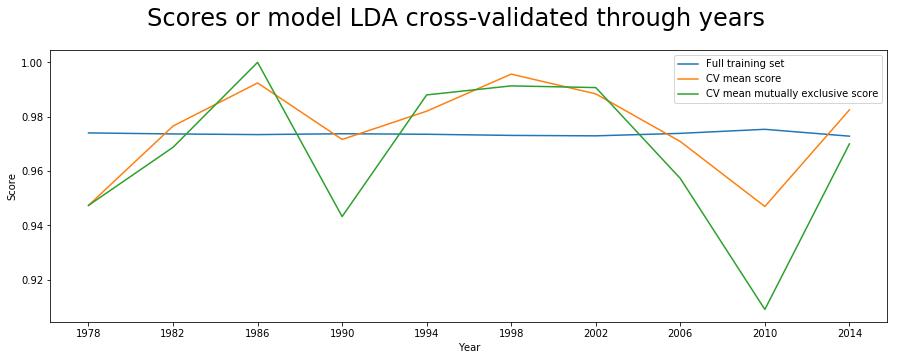

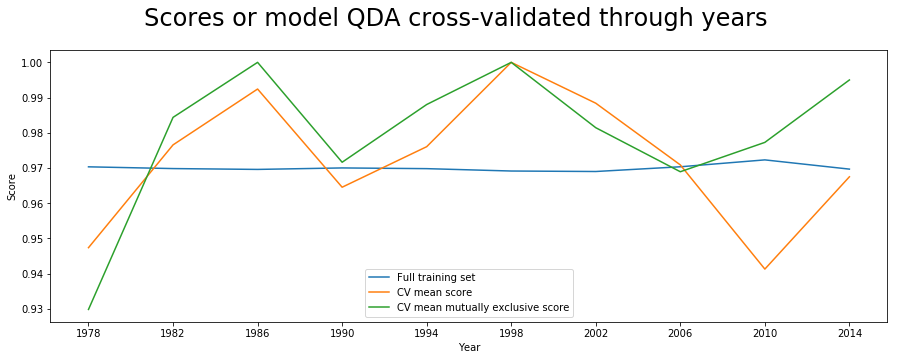

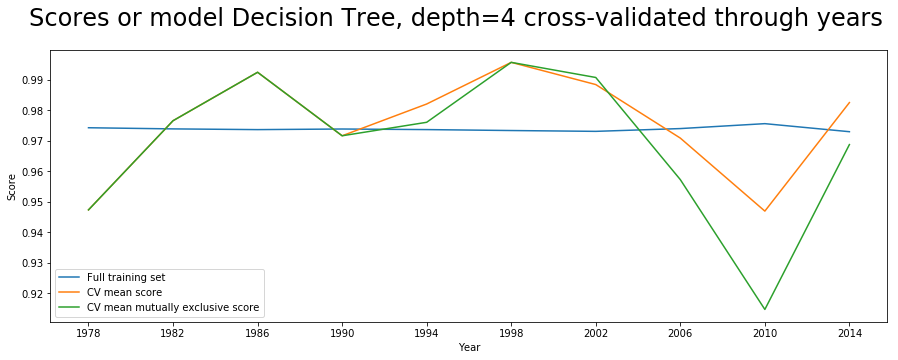

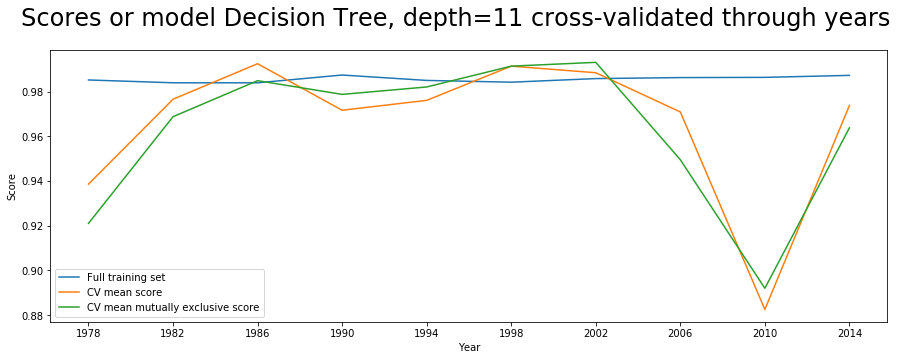

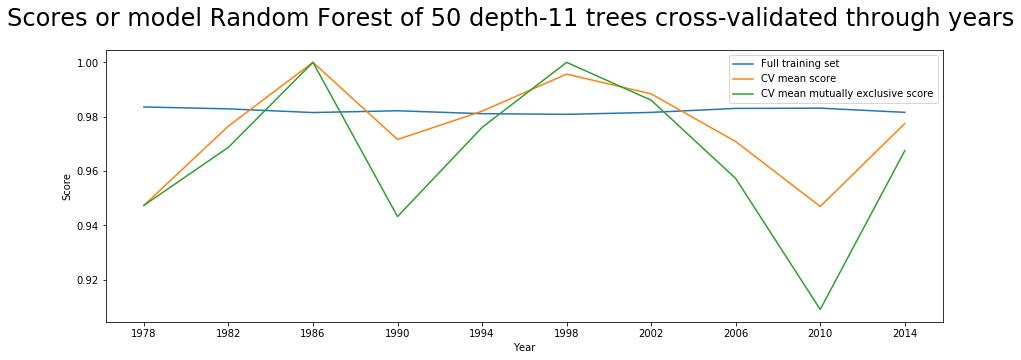

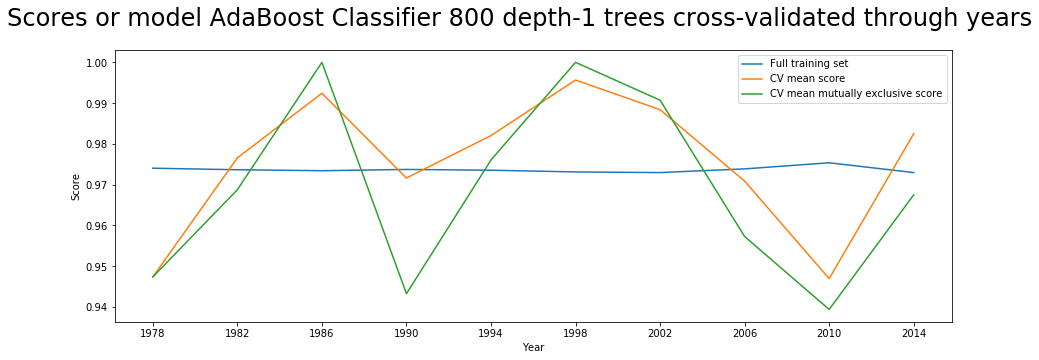

In [18]:
modelListTrain(modelList, train_data, years)

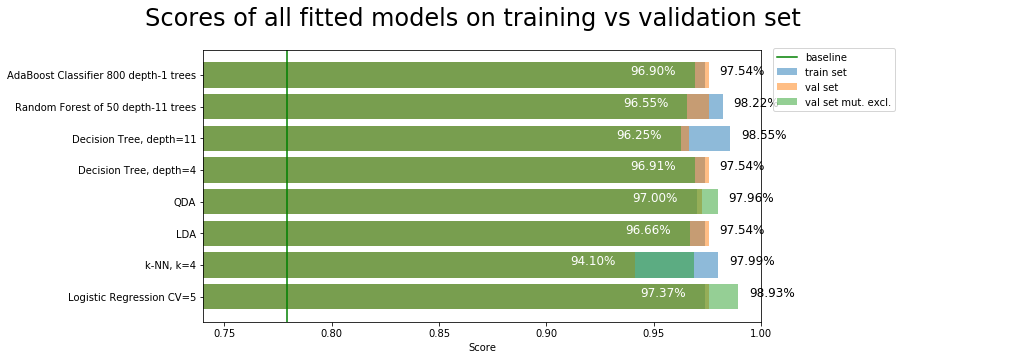

In [19]:
baseline_accuracy=0.7793 
plotModelsScores(modelList, baseline_accuracy)

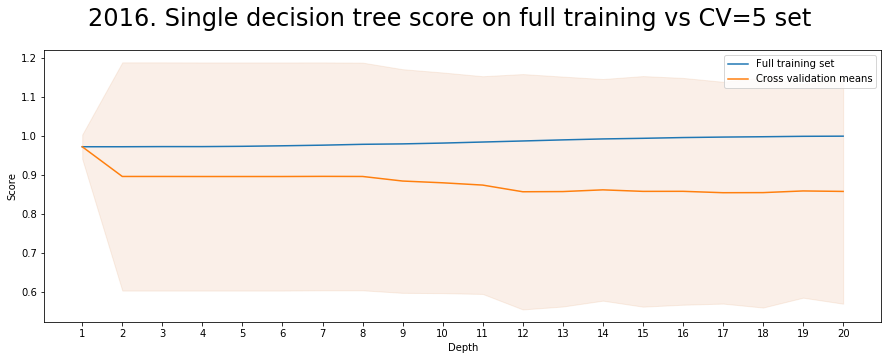

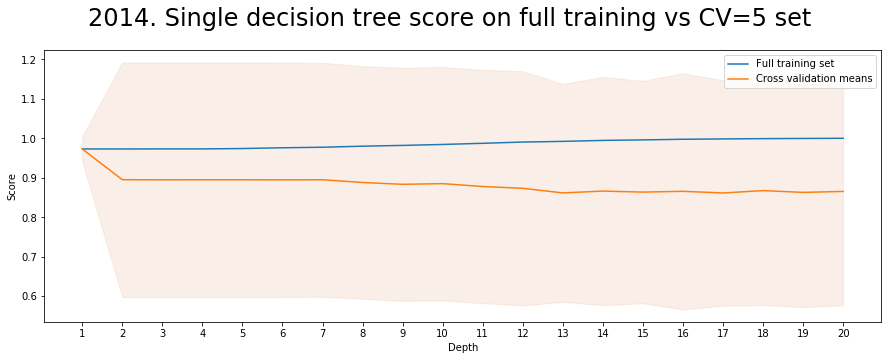

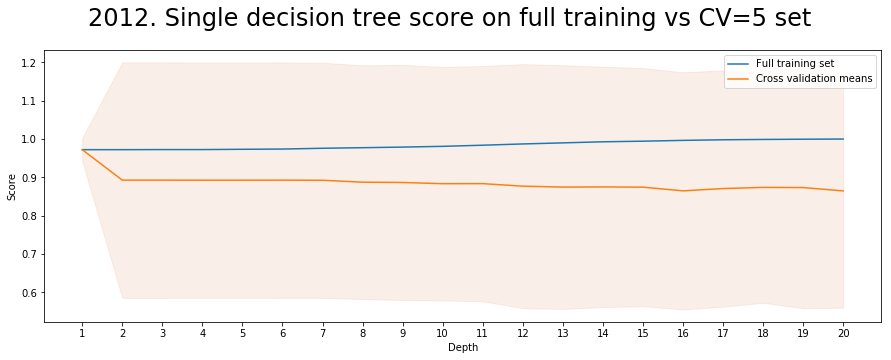

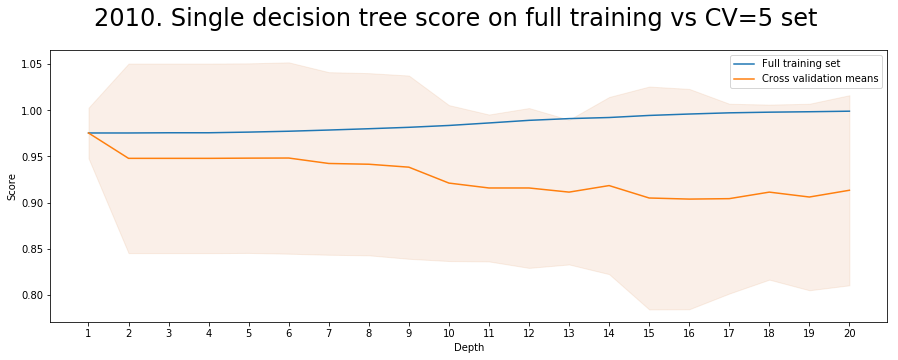

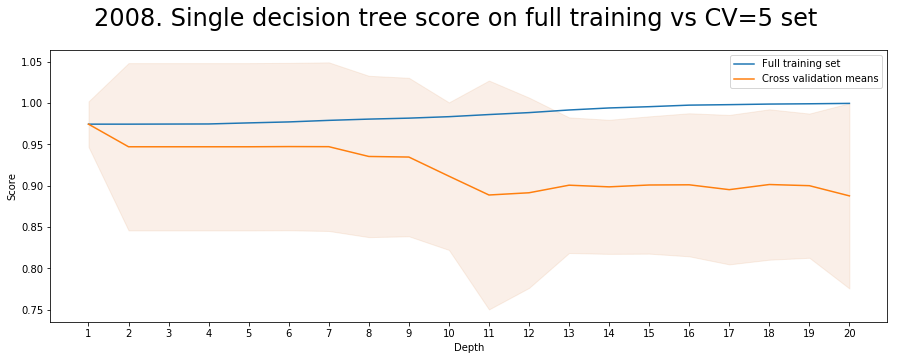

In [20]:
#find best depth for decision tree
#years=Midterm_recent_years
years=All_recent_years[:5]
for year in years:
    #split dataset
    x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

    #preprocess
    x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
    x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_preprocess=x_train_preprocess[list(x_val_preprocess)]

    #fit model
    depths=list(range(1,21)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_preprocess, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_preprocess, y_train)
        scores_train.append(dt.score(x_train_preprocess, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [21]:
#one shot prediction
model=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)

#split dataset using 2018 data as test set
year=2018
x_train, y_train, x_test, y_test, house_df_districts = splitDf(house_df[(house_df['year']>=yearStart)], year)

#preprocess
x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

#fit model
fitted_model=model.fit(x_train_preprocess, y_train)

#generate predictions and calculate accuracy
Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

#print accuracy scores
print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

#print how many republican, how many democrat districts
DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

#print uncertainties
uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
n_uncertainties=len(uncertainties)
print('Uncertainties: {}\n'.format(n_uncertainties))

#Consolidate district results by party, instead that by candidate

Training accuracy: 97.37%
Validation accuracy: 97.02%
Mutually exclusive validation accuracy: 99.76%

N. Democrat districts: 229
N. Republican districts: 206
Uncertainties: 50



In [22]:
#Consolidate district results by party, instead that by candidate
winner_pred=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
actual_winners=test_data[test_data['won']==1].set_index(['state', 'district']).sort_index()
#display(winner_pred['won_pred'].astype(int).head())
#display(actual_winners['won'].astype(int).head())
final_results=pd.DataFrame(columns = ['won', 'won_pred'] )
final_results['won_pred']=winner_pred['party'].astype(int).replace([0, 1], ['D', 'R'])
final_results['won']=actual_winners['party']
final_results['correct_pred']=(final_results['won_pred']==final_results['won'])
print('Correct predictions: {} on a total of {} districts ({:.2%})\n'.format(sum(final_results['correct_pred']),
                                                                       len(final_results['correct_pred']),
                                                                       sum(final_results['correct_pred'])/len(final_results['correct_pred'])))

#print how many republican, how many democrat districts
DEM=final_results[final_results['won_pred']=='D']
REP=final_results[final_results['won_pred']=='R']
print('Predictions:\nN. Democrat districts: {}\nN. Republican districts: {}\n'.format(len(DEM), len(REP)))
DEM=final_results[final_results['won']=='D']
REP=final_results[final_results['won']=='R']
print('Actual results:\nN. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))
final_results['abs_won_proba']=winner_pred['abs_won_proba']
final_results['rel_won_proba']=winner_pred['rel_won_proba']

print('\nFirst 5 correct predictions:')
display(final_results[final_results['correct_pred']==True].head())

print('List of wrong predictions:')
display(final_results[final_results['correct_pred']==False])
#winner_pred['won_pred'].astype(int)==actual_winners['won'].astype(int)

Correct predictions: 434 on a total of 435 districts (99.77%)

Predictions:
N. Democrat districts: 229
N. Republican districts: 206

Actual results:
N. Democrat districts: 230
N. Republican districts: 205

First 5 correct predictions:


won won_pred  correct_pred  abs_won_proba  rel_won_proba
state   district                                                           
Alabama District 1   R        R          True       0.962430       0.999977
        District 2   R        R          True       0.961681       0.999977
        District 3   R        R          True       0.962070       0.999977
        District 4   R        R          True       0.962062       0.999977
        District 5   R        R          True       0.961652       0.999977

List of wrong predictions:


,,won,won_pred,correct_pred,abs_won_proba,rel_won_proba
state,district,,,,,
Nevada,District 4,D,R,False,0.962557,0.50013


In [23]:
#house_df[(house_df['state']=='Louisiana')&(house_df['district']=='District 3')&(house_df['year']==2018)]
#house_df[(house_df['state']=='California')&(house_df['district']=='District 17')&(house_df['year']==2014)]
house_df[(house_df['state']=='Colorado')&(house_df['district']=='District 3')&(house_df['year']==2014)]
#house_df.iloc[[9600, 9801, 9813, 9904], :] #9600, 9801, 9813, 9904

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
8016,District 3,0.0,Abel Tapia,D,35.7,Colorado,100364,0,2014,0.0,0,6.7,0.0,0.0,D,0.48,201.0,234.0,R,279186.35
8018,District 3,1.0,Scott Tipton,R,58.0,Colorado,163011,1,2014,2010.0,2,6.7,0.0,0.0,D,0.48,201.0,234.0,R,1284602.01


(array([380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 460.]),
 array([2.22516323e-05, 9.63707168e-02, 1.92719182e-01, 2.89067647e-01,
        3.85416112e-01, 4.81764577e-01, 5.78113042e-01, 6.74461507e-01,
        7.70809973e-01, 8.67158438e-01, 9.63506903e-01]),
 <a list of 10 Patch objects>)

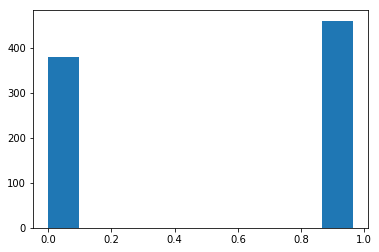

In [24]:
plt.hist(pred_df['abs_won_proba'])

(array([380.,   0.,   0.,   0.,  26.,  24.,   0.,   0.,   0., 410.]),
 array([2.31123085e-05, 1.00020801e-01, 2.00018490e-01, 3.00016179e-01,
        4.00013867e-01, 5.00011556e-01, 6.00009245e-01, 7.00006934e-01,
        8.00004622e-01, 9.00002311e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

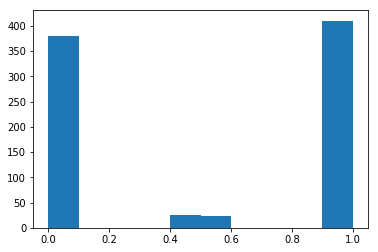

In [25]:
plt.hist(pred_df['rel_won_proba'])